# Riot Churn Predictor [Part 2 - Data Cleaning and Modeling]

**David Skarbrevik - 2018**

In part 1 we acquired League of Legends player gameplay data. Now we want to use that data to build a model that complete some sort of churn-like prediction task based on this data.

<a id="toc"></a>

<br>
<hr style="background-color: black; padding: 1px;">
<br>

<h2>Table of Contents</h2>

<br>

<ol>
    <li><a href="#section1">Planning</a></li>
    <br>
    <li><a href="#section2">Data cleaning</a></li>
    <br>
    <li><a href="#section3">Prepparing the data for modeling</a></li>
    <br>
    <li><a href="#section4">Modeling the data</a></li>   
</ol>

<br>
<hr style="background-color: black; padding: 1px;">
<br>

<a id='section1'></a>

## Step 1) Planning

### What prediction tasks to model?

Some possibilities:

* Will the summoner get to level 3 or higher within the first month of play?
* Did the summoner play more than 1 match?
* Did the summoner play at least X matches?



### What types of models to try?

I will start with logistic regression. If that does not achieve reasonable results, I will move to a simple neural network. 

***

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section2'></a>

## Step 2) Data Cleaning

In [72]:
import pandas as pd
import numpy as np
from collections import Counter

In [16]:
# this dataset has over 100 columns so pandas will truncate our results by default
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

**Import data**

In [17]:
df = pd.read_csv("riot_master_df.csv", encoding="ISO-8859-1")

**Overview of Data**

In [18]:
df.head()

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
0,16.0,12.0,0.0,5.1,0.0,0.0,0.0,4.80,0.0,0.0,0.0,4624.0,4624.0,4268.0,-205.3,0.0,0.0,0.0,388.2,0.0,0.0,0.0,0.0,0.0,False,False,True,False,False,False,0 days 00:14:00.000000000,2695060245,2018-01-16T05:50:54.986000+00:00,8012.0,496.3,0.0,0.0,0.0,2850.0,4.0,0.0,1054.0,3044.0,3067.0,1001.0,0.0,0.0,3340.0,1.0,13.0,MIDDLE,456.0,13.0,1.0,2018-01-17T06:05:14.227000+00:00,0.0,3005.0,2392.0,1005.0,0.0,0.0,0.0,0.0,4.0,0.0,8400.0,8200.0,48136.0,11330.0,7246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SOLO,0.0,92201075,5,TrEx18,18.0,51142.0,13723.0,8252.0,1128.0,63.0,0.0,0.0,274.0,1.0,7,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,371.20,0.0,0.0,0.0,583.9,0.0,0.0,0.0
1,4.0,11.0,0.0,3.5,0.0,0.0,0.0,1.72,0.0,0.0,0.0,1885.0,1885.0,5206.0,-200.0,0.0,0.0,0.0,478.0,0.0,0.0,0.0,2.0,3.0,False,False,False,False,False,False,0 days 00:16:41.000000000,2736710108,2018-03-10T06:24:33.477000+00:00,9014.0,318.3,0.0,0.0,0.0,8850.0,2.0,0.0,3142.0,3147.0,3111.0,1043.0,1036.0,1055.0,3340.0,2.0,13.0,NONE,0.0,9.0,2.0,2018-03-10T14:58:21.007000+00:00,654.0,968.0,888.0,3374.0,4.0,4.0,0.0,0.0,2.0,0.0,8100.0,8000.0,46817.0,12594.0,7109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,93650017,5,iMain N01,59.0,52490.0,13817.0,11503.0,3662.0,58.0,0.0,0.0,123.0,1.0,6,0.0,4704.0,334.0,1019.0,0.0,0.0,3.0,0.0,0.0,3.0,True,84.66,0.0,0.0,0.0,363.9,0.0,0.0,0.0
2,10.0,13.0,0.0,0.8,3.6,0.0,0.0,NaN,NaN,NaN,NaN,6838.0,5972.0,11147.0,NaN,NaN,NaN,NaN,564.3,862.1,0.0,0.0,2.0,0.0,False,False,True,False,False,False,0 days 00:22:54.000000000,2736716714,2018-03-10T06:56:11.750000+00:00,10869.0,353.0,412.7,0.0,0.0,6800.0,2.0,0.0,2003.0,1055.0,3133.0,3071.0,3076.0,3086.0,3340.0,3.0,10.0,JUNGLE,499.0,5.0,1.0,2018-03-21T08:32:17.048000+00:00,419.0,1229.0,288.0,2291.0,16.0,0.0,13.0,0.0,2.0,0.0,8100.0,8000.0,67383.0,10907.0,14573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NONE,0.0,92729877,5,luexolu99,36.0,70890.0,11789.0,16942.0,879

In [19]:
df.shape

(1598, 116)

**Is there missing data?**

In [20]:
if df[df.isnull().any(axis=1)].empty:
    print("No missing values!")
else:
    print("Missing data from {} rows".format(df[df.isnull().any(axis=1)].shape[0]))

Missing data from 462 rows


**What columns are missing data?**

In [21]:
df.isnull().sum()

assists                                 1
champLevel                              1
combatPlayerScore                       1
creepsPerMinDeltas_0-10                 5
creepsPerMinDeltas_10-20                5
creepsPerMinDeltas_20-30                5
creepsPerMinDeltas_30-end               5
csDiffPerMinDeltas_0-10               446
csDiffPerMinDeltas_10-20              446
csDiffPerMinDeltas_20-30              446
csDiffPerMinDeltas_30-end             446
damageDealtToObjectives                 1
damageDealtToTurrets                    1
damageSelfMitigated                     1
damageTakenDiffPerMinDeltas_0-10      446
damageTakenDiffPerMinDeltas_10-20     446
damageTakenDiffPerMinDeltas_20-30     446
damageTakenDiffPerMinDeltas_30-end    446
damageTakenPerMinDeltas_0-10            5
damageTakenPerMinDeltas_10-20           5
damageTakenPerMinDeltas_20-30           5
damageTakenPerMinDeltas_30-end          5
deaths                                  1
doubleKills                       

**Dealing with the missing data**

We see that a lot of the columns are only missing 1 data point, this could be from a single player. Let's take a look:

In [22]:
df.loc[df['assists'].isnull()]

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:28,2717262656,2018-02-12T21:53:43.622000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOP,NaN,NaN,NaN,2018-02-15T18:09:10.473000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DUO,NaN,92790619,3,ChiefShonah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Perhaps this player left his first game right as it started? Though if that is the reason, it's amazing there aren't at least a few more cases in our dataset like this. 

Let's see what the NaN column counts look like after we remove this player.

In [23]:
df = df.drop(df.index[982]) # drop one specific player

In [24]:
df.isnull().sum()

assists                                 0
champLevel                              0
combatPlayerScore                       0
creepsPerMinDeltas_0-10                 4
creepsPerMinDeltas_10-20                4
creepsPerMinDeltas_20-30                4
creepsPerMinDeltas_30-end               4
csDiffPerMinDeltas_0-10               445
csDiffPerMinDeltas_10-20              445
csDiffPerMinDeltas_20-30              445
csDiffPerMinDeltas_30-end             445
damageDealtToObjectives                 0
damageDealtToTurrets                    0
damageSelfMitigated                     0
damageTakenDiffPerMinDeltas_0-10      445
damageTakenDiffPerMinDeltas_10-20     445
damageTakenDiffPerMinDeltas_20-30     445
damageTakenDiffPerMinDeltas_30-end    445
damageTakenPerMinDeltas_0-10            4
damageTakenPerMinDeltas_10-20           4
damageTakenPerMinDeltas_20-30           4
damageTakenPerMinDeltas_30-end          4
deaths                                  0
doubleKills                       

OK, most of the columns don't have NaNs now, but a lot have exactly 4 or 445 missing values. These are all features with a time component, so it is likely that these games just didn't go long enough to produce values. However, because the 0-10min category also has 445 missing values it's possible that these are all players that dropped their first game shortly after joining the match. It should be appropriate to set those columns to 0.

But let's see what the data for these players looks like before we do that:

In [25]:
df.loc[df['xpDiffPerMinDeltas_0-10'].isnull()].head(n=10) # just choosing one of the time features, doesn't matter

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
2,10.0,13.0,0.0,0.8,3.6,0.0,0.0,NaN,NaN,NaN,NaN,6838.0,5972.0,11147.0,NaN,NaN,NaN,NaN,564.3,862.1,0.0,0.0,2.0,0.0,False,False,True,False,False,False,0 days 00:22:54.000000000,2736716714,2018-03-10T06:56:11.750000+00:00,10869.0,353.0,412.7,0.0,0.0,6800.0,2.0,0.0,2003.0,1055.0,3133.0,3071.0,3076.0,3086.0,3340.0,3.0,10.0,JUNGLE,499.0,5.0,1.0,2018-03-21T08:32:17.048000+00:00,419.0,1229.0,288.0,2291.0,16.0,0.0,13.0,0.0,2.0,0.0,8100.0,8000.0,67383.0,10907.0,14573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NONE,0.0,92729877,5,luexolu99,36.0,70890.0,11789.0,16942.0,8791.0,50.0,0.0,0.0,145.0,1.0,4,0.0,2277.0,593.0,77.0,2.0,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,331.8,464.2,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,0 days 00:28:54.000000000,2736217337,2018-03-09T13:05:59.377000+00:00,5089.0,100.0,164.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOP,0.0,0.0,0.0,2018-03-09T13:05:59.377000+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,8400.0,8200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,93839689,1,Md95359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
5,7.0,15.0,0.0,3.5,5.4,0.0,0.0,NaN,NaN,NaN,NaN,2130.0,2130.0,16903.0,NaN,NaN,NaN,NaN,321.5,740.3,0.0,0.0,5.0,3.0,False,False,True,False,False,False,0 days 00:26:05.000000000,2741305286,2018-03-16T20:15:31.237000+00:00,12784.0,386.4,518.8,0.0,0.0,12200.0,5.0,0.0,3072.0,3046.0,1029.0,3006.0,3031.0,0.0,3340.0,3.0,14.0,MIDDLE,665.0,7.0,2.0,2018-03-18T07:38:08.817000+00:00,780.0,6271.0,704.0,6075.0,12.0,8.0,4.0,0.0,5.0,0.0,8000.0,8200.0,106662.0,30303.0,11636.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO,0.0,93782084,5,Häsagi,40.0,112934.0,31008.0,18013.0,1967.0,109.0,0.0,0.0,110.0,1.0,6,0.0,0.0,0.0,301.0,1.0,0.0,0.0,0.0,0.0,0.0,True,Na

It appears that the these players actually did play their first match through, there was just an issue collecting the "timeline" data. 

**Possible solutions:**

**1) set all timeline NaNs to 0**

2) drop all timeline data from dataset

3) take summoner ids that have NaNs and re-mine their data to see if I can get it

**I'm going to try option 1**, but ultimately I'll want to take the time to do option 3 to reduce noise in my data and models.

In [26]:
time_columns = [i for i,x in enumerate(df.isnull().sum().tolist()) if x == 445 or x == 4] # columns with missing time data
time_cols = list(df.iloc[:, time_columns])
values = {col:0 for col in time_cols}
df = df.fillna(value = values)

In [27]:
df.isnull().sum()

assists                                0
champLevel                             0
combatPlayerScore                      0
creepsPerMinDeltas_0-10                0
creepsPerMinDeltas_10-20               0
creepsPerMinDeltas_20-30               0
creepsPerMinDeltas_30-end              0
csDiffPerMinDeltas_0-10                0
csDiffPerMinDeltas_10-20               0
csDiffPerMinDeltas_20-30               0
csDiffPerMinDeltas_30-end              0
damageDealtToObjectives                0
damageDealtToTurrets                   0
damageSelfMitigated                    0
damageTakenDiffPerMinDeltas_0-10       0
damageTakenDiffPerMinDeltas_10-20      0
damageTakenDiffPerMinDeltas_20-30      0
damageTakenDiffPerMinDeltas_30-end     0
damageTakenPerMinDeltas_0-10           0
damageTakenPerMinDeltas_10-20          0
damageTakenPerMinDeltas_20-30          0
damageTakenPerMinDeltas_30-end         0
deaths                                 0
doubleKills                            0
firstBloodAssist

OK now there are a few more features with NaNs. 

Let's look at "perkSubStyle":

In [28]:
df.loc[df['perkSubStyle'].isnull()].head(n=10)

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
226,3.0,9.0,0.0,0.3,0.0,0.0,0.0,1.44,0.00,0.0,0.0,3619.0,3619.0,5428.0,-36.42,0.00,0.0,0.0,415.5,0.0,0.0,0.0,6.0,0.0,False,False,False,False,False,False,0 days 00:19:04.000000000,2736312050,2018-03-09T20:23:32.929000+00:00,6213.0,171.3,0.0,0.0,0.0,1250.0,5.0,0.0,1056.0,1026.0,0.0,0.0,0.0,0.0,3341.0,0.0,1.0,NONE,0.0,0.0,1.0,2018-03-17T17:44:56.142000+00:00,251.0,9006.0,1256.0,2489.0,0.0,0.0,0.0,0.0,5.0,0.0,8200.0,NaN,7273.0,854.0,5197.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,93689587,5,spicyemperor908,0.0,23342.0,2782.0,7687.0,1359.0,20.0,0.0,0.0,15.0,3.0,9,0.0,7062.0,672.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,83.02,0.0,0.0,0.0,153.9,0.0,0.0,0.0
269,4.0,14.0,0.0,3.4,2.2,0.0,0.0,0.00,0.00,0.0,0.0,3245.0,3245.0,11722.0,0.00,0.00,0.0,0.0,139.1,706.7,0.0,0.0,0.0,0.0,False,False,False,False,False,True,0 days 00:29:06.000000000,2736833894,2018-03-10T14:20:37.391000+00:00,12213.0,336.0,364.7,0.0,0.0,5300.0,2.0,0.0,1054.0,1054.0,3044.0,3111.0,3067.0,3044.0,3340.0,1.0,16.0,MIDDLE,0.0,16.0,1.0,2018-03-11T03:25:16.314000+00:00,0.0,7765.0,4105.0,5165.0,2.0,2.0,0.0,0.0,2.0,0.0,8400.0,NaN,55694.0,14893.0,9645.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_CARRY,0.0,93879843,5,GregJuan,20.0,67435.0,18999.0,14810.0,1486.0,74.0,0.0,0.0,157.0,1.0,5,0.0,3975.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,0.00,0.0,0.0,0.0,516.9,320.8,0.0,0.0
272,15.0,7.0,0.0,0.4,0.0,0.0,0.0,0.94,0.00,0.0,0.0,862.0,862.0,2395.0,-385.64,0.00,0.0,0.0,338.9,0.0,0.0,0.0,4.0,0.0,False,False,True,False,True,False,0 days 00:12:28.000000000,2743505380,2018-03-19T05:31:31.571000+00:00,4463.0,299.7,0.0,0.0,0.0,3150.0,2.0,0.0,3111.0,3044.0,3067.0,0.0,0.0,0.0,3340.0,1.0,3.0,NONE,0.0,2.0,1.0,2018-03-19T06:07:50.345000+00:00,242.0,611.0,443.0,249.0,0.0,0.0,0.0,0.0,2.0,0.0,8400.0,NaN,9466.0,2954.0,4761.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,27808934,4,DeathOni,5.0,12818.0,3397.0,5011.0,65.0,7.0,0.0,0.0,65.0

What are some normal values for this feature?

In [29]:
Counter(df['perkSubStyle'])

Counter({8000.0: 234,
         8100.0: 504,
         8200.0: 843,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1})

I'm not sure what this feature describes, but because not all players have just one value, this may be a useful feature. Because only a small percent of players are missing this value, I am simply going to remove those players from the dataset.

In [30]:
perksub_nan = list(df.loc[df['perkSubStyle'].isnull()].index.values)
df = df.drop(perksub_nan)

Now let's look at the last 4 features with NaN values:

In [31]:
features_with_nan = ["firstInhibitorAssist", "firstInhibitorKill", "firstTowerAssist", "firstTowerKill"]

for feature in features_with_nan:
    print("Feature name: {}".format(feature))
    print(Counter(df[feature]))
    print("\n")

Feature name: firstInhibitorAssist
Counter({False: 1274, True: 302, nan: 5})


Feature name: firstInhibitorKill
Counter({False: 1388, True: 188, nan: 5})


Feature name: firstTowerAssist
Counter({False: 1389, True: 191, nan: 1})


Feature name: firstTowerKill
Counter({False: 1379, True: 201, nan: 1})




As with the 'perkSubStyle' feature there are only a few players with NaN values in the features above. I don't want to randomly assign True or False to these players so I will simply drop them.

In [32]:
nan_index = sum([list(df.loc[df[feature].isnull()].index.values) for feature in features_with_nan], [])
df = df.drop(nan_index)

Let's make sure we don't have any more NaN values:

In [33]:
if df[df.isnull().any(axis=1)].empty:
    print("No missing values!")
else:
    print("Missing data from {} rows".format(df[df.isnull().any(axis=1)].shape[0]))

No missing values!


**Dealing with duplicate rows**

In [34]:
print("Number of duplicate rows in dataset: {}".format(Counter(df.duplicated())[True]))

Number of duplicate rows in dataset: 81


In [35]:
old_rows = df.shape[0]

df = df.drop_duplicates()

new_rows = df.shape[0]

diff = old_rows - new_rows

print("Number of rows removed: {}".format(diff))

Number of rows removed: 81


Good, the number of rows we removed equals the number of duplicate rows so that's a good sign! Ideally there would have been 0 duplicate rows, because I have a check in my data collection functions to try and avoid this. But for now we'll just remove our duplicates.

Now let's rearrange some of the features that tell us about a player but won't be useful in training our model. This will make this a more interesting "at first glance" dataset.

In [36]:
columns = list(df)
front_features = ['summoner_id', 'summoner_name', 'summoner_level', 'total_matches',
                  'first_match_time', 'first_match_duration', 'first_match_id']

In [37]:
len(columns)

116

In [38]:
cols_reordered = [item for item in columns if item not in front_features]
cols_reordered = front_features + cols_reordered

In [39]:
df = df[cols_reordered]

In [40]:
df.head()

,summoner_id,summoner_name,summoner_level,total_matches,first_match_time,first_match_duration,first_match_id,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
0,92201075,TrEx18,5,7,2018-01-16T05:50:54.986000+00:00,0 days 00:14:00.000000000,2695060245,16.0,12.0,0.0,5.1,0.0,0.0,0.0,4.80,0.0,0.0,0.0,4624.0,4624.0,4268.0,-205.3,0.0,0.0,0.0,388.2,0.0,0.0,0.0,0.0,0.0,False,False,True,False,False,False,8012.0,496.3,0.0,0.0,0.0,2850.0,4.0,0.0,1054.0,3044.0,3067.0,1001.0,0.0,0.0,3340.0,1.0,13.0,MIDDLE,456.0,13.0,1.0,2018-01-17T06:05:14.227000+00:00,0.0,3005.0,2392.0,1005.0,0.0,0.0,0.0,0.0,4.0,0.0,8400.0,8200.0,48136.0,11330.0,7246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SOLO,0.0,18.0,51142.0,13723.0,8252.0,1128.0,63.0,0.0,0.0,274.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,371.20,0.0,0.0,0.0,583.9,0.0,0.0,0.0
1,93650017,iMain N01,5,6,2018-03-10T06:24:33.477000+00:00,0 days 00:16:41.000000000,2736710108,4.0,11.0,0.0,3.5,0.0,0.0,0.0,1.72,0.0,0.0,0.0,1885.0,1885.0,5206.0,-200.0,0.0,0.0,0.0,478.0,0.0,0.0,0.0,2.0,3.0,False,False,False,False,False,False,9014.0,318.3,0.0,0.0,0.0,8850.0,2.0,0.0,3142.0,3147.0,3111.0,1043.0,1036.0,1055.0,3340.0,2.0,13.0,NONE,0.0,9.0,2.0,2018-03-10T14:58:21.007000+00:00,654.0,968.0,888.0,3374.0,4.0,4.0,0.0,0.0,2.0,0.0,8100.0,8000.0,46817.0,12594.0,7109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,59.0,52490.0,13817.0,11503.0,3662.0,58.0,0.0,0.0,123.0,1.0,0.0,4704.0,334.0,1019.0,0.0,0.0,3.0,0.0,0.0,3.0,True,84.66,0.0,0.0,0.0,363.9,0.0,0.0,0.0
2,92729877,luexolu99,5,4,2018-03-10T06:56:11.750000+00:00,0 days 00:22:54.000000000,2736716714,10.0,13.0,0.0,0.8,3.6,0.0,0.0,0.00,0.0,0.0,0.0,6838.0,5972.0,11147.0,0.0,0.0,0.0,0.0,564.3,862.1,0.0,0.0,2.0,0.0,False,False,True,False,False,False,10869.0,353.0,412.7,0.0,0.0,6800.0,2.0,0.0,2003.0,1055.0,3133.0,3071.0,3076.0,3086.0,3340.0,3.0,10.0,JUNGLE,499.0,5.0,1.0,2018-03-21T08:32:17.048000+00:00,419.0,1229.0,288.0,2291.0,16.0,0.0,13.0,0.0,2.0,0.0,8100.0,8000.0,67383.0,10907.0,14573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NONE,0.0,36.0,70890.0,11789.0,16942.0,

Lastly, let's save this dataset as a "cleaned_riot_data.csv" file for future use.

In [41]:
df.to_csv("cleaned_riot_data.csv", index=False)

### Overview of cleaning steps:

1) removed one player with almost no data 

2) players with feature 'perkSubStyle' = NaN were removed (there were only a few and I'm not sure what that feature describes)

3) changed many time data values to 0 

4) removed duplicate rows

5) restructure some rows just to make it look nicer

6) saved the cleaned dataset as csv file

**IMPORTANT NOTE:** At some point, I will need to review steps (2) and (3) as there may be better solutions for those issues.

***

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section3'></a>

## Step 3) Prepping the data for modeling

**There are four things we need to do before training any models:**

**1)** OHE encode categorical and binary features

**2) [optional]** normalize values (many columns have large values)

**3)** create a "label" feature that we will predict on

**4)** remove unwanted features from the dataset

**5)** randomize and split data into a train/test sets

<br>

**First, read cleaned dataframe from file**

In [105]:
df = pd.read_csv("cleaned_riot_data.csv", encoding="ISO-8859-1")

**1) OHE encoding for categorical features**

In [106]:
[(feature, Counter(df[feature].head(n=3))) for feature in list(df)] # which features are categorical?

[('summoner_id', Counter({92201075: 1, 92729877: 1, 93650017: 1})),
 ('summoner_name', Counter({'TrEx18': 1, 'iMain N01': 1, 'luexolu99': 1})),
 ('summoner_level', Counter({5: 3})),
 ('total_matches', Counter({4: 1, 6: 1, 7: 1})),
 ('first_match_time',
  Counter({'2018-01-16T05:50:54.986000+00:00': 1,
           '2018-03-10T06:24:33.477000+00:00': 1,
           '2018-03-10T06:56:11.750000+00:00': 1})),
 ('first_match_duration',
  Counter({'0 days 00:14:00.000000000': 1,
           '0 days 00:16:41.000000000': 1,
           '0 days 00:22:54.000000000': 1})),
 ('first_match_id', Counter({2695060245: 1, 2736710108: 1, 2736716714: 1})),
 ('assists', Counter({4.0: 1, 10.0: 1, 16.0: 1})),
 ('champLevel', Counter({11.0: 1, 12.0: 1, 13.0: 1})),
 ('combatPlayerScore', Counter({0.0: 3})),
 ('creepsPerMinDeltas_0-10',
  Counter({0.80000000000000004: 1, 3.5: 1, 5.0999999999999996: 1})),
 ('creepsPerMinDeltas_10-20', Counter({0.0: 2, 3.6000000000000001: 1})),
 ('creepsPerMinDeltas_20-30', Counter({

Looks like just the 'lane' and 'role' features are categorical so let's OHE those. 

Note also, there are a couple True/False columns. Python and python libraries usually treats them as 1/0 already but we'll explicitly change them just in case it causes trouble later.

In [107]:
dummy_lane = pd.get_dummies(df['lane'])
dummy_role = pd.get_dummies(df['role'])

dummy_role.columns.values[3] = "NO_ROLE"
dummy_lane.columns.values[3] = "NO_LANE"

In [108]:
dummy_lane.head()

,BOTTOM,JUNGLE,MIDDLE,NO_LANE,TOP
0,0,0,1,0,0
1,0,0,0,1,0
2,0,1,0,0,0
3,0,0,0,0,1
4,0,1,0,0,0


In [109]:
dummy_role.head()

,DUO,DUO_CARRY,DUO_SUPPORT,NO_ROLE,SOLO
0,0,0,0,0,1
1,0,0,1,0,0
2,0,0,0,1,0
3,0,0,1,0,0
4,0,0,0,1,0


In [110]:
df = df.drop(['lane', 'role'], axis=1)
df = df.join([dummy_role,dummy_lane])

In [111]:
boolean_features = ['firstBloodAssist', 'firstBloodKill', 'firstInhibitorAssist', 
                    'firstInhibitorKill', 'firstTowerAssist', 'firstTowerKill', 'win']

df[boolean_features] = df[boolean_features].astype(int)

Let's just make sure all our features are numeric now:

In [112]:
df.head()

,summoner_id,summoner_name,summoner_level,total_matches,first_match_time,first_match_duration,first_match_id,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,sightWardsBoughtInGame,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end,DUO,DUO_CARRY,DUO_SUPPORT,NO_ROLE,SOLO,BOTTOM,JUNGLE,MIDDLE,NO_LANE,TOP
0,92201075,TrEx18,5,7,2018-01-16T05:50:54.986000+00:00,0 days 00:14:00.000000000,2695060245,16.0,12.0,0.0,5.1,0.0,0.0,0.0,4.80,0.0,0.0,0.0,4624.0,4624.0,4268.0,-205.3,0.0,0.0,0.0,388.2,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,8012.0,496.3,0.0,0.0,0.0,2850.0,4.0,0.0,1054.0,3044.0,3067.0,1001.0,0.0,0.0,3340.0,1.0,13.0,456.0,13.0,1.0,2018-01-17T06:05:14.227000+00:00,0.0,3005.0,2392.0,1005.0,0.0,0.0,0.0,0.0,4.0,0.0,8400.0,8200.0,48136.0,11330.0,7246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,51142.0,13723.0,8252.0,1128.0,63.0,0.0,0.0,274.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1,371.20,0.0,0.0,0.0,583.9,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0
1,93650017,iMain N01,5,6,2018-03-10T06:24:33.477000+00:00,0 days 00:16:41.000000000,2736710108,4.0,11.0,0.0,3.5,0.0,0.0,0.0,1.72,0.0,0.0,0.0,1885.0,1885.0,5206.0,-200.0,0.0,0.0,0.0,478.0,0.0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,9014.0,318.3,0.0,0.0,0.0,8850.0,2.0,0.0,3142.0,3147.0,3111.0,1043.0,1036.0,1055.0,3340.0,2.0,13.0,0.0,9.0,2.0,2018-03-10T14:58:21.007000+00:00,654.0,968.0,888.0,3374.0,4.0,4.0,0.0,0.0,2.0,0.0,8100.0,8000.0,46817.0,12594.0,7109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,52490.0,13817.0,11503.0,3662.0,58.0,0.0,0.0,123.0,1.0,0.0,4704.0,334.0,1019.0,0.0,0.0,3.0,0.0,0.0,3.0,1,84.66,0.0,0.0,0.0,363.9,0.0,0.0,0.0,0,0,1,0,0,0,0,0,1,0
2,92729877,luexolu99,5,4,2018-03-10T06:56:11.750000+00:00,0 days 00:22:54.000000000,2736716714,10.0,13.0,0.0,0.8,3.6,0.0,0.0,0.00,0.0,0.0,0.0,6838.0,5972.0,11147.0,0.0,0.0,0.0,0.0,564.3,862.1,0.0,0.0,2.0,0.0,0,0,1,0,0,0,10869.0,353.0,412.7,0.0,0.0,6800.0,2.0,0.0,2003.0,1055.0,3133.0,3071.0,3076.0,3086.0,3340.0,3.0,10.0,499.0,5.0,1.0,2018-03-21T08:32:17.048000+00:00,419.0,1229.0,288.0,2291.0,16.0,0.0,13.0,0.0,2.0,0.0,8100.0,8000.0,67383.0,10907.0,14573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,70890.0,11789.0,16942.0,8791.0,50.0,0.0

Looks good, let's move on.

**2) Normalize feature values**

In [ ]:
# skipping this for now

**3) Create a prediction task label feature**

We are trying to predict, from a player's first match stats, if they will play enough to reach summoner level 3 or greater. 

Let's see what the summoner level breakdown for players is in this dataset.

In [113]:
level_counts = Counter(df['summoner_level'])
level_counts

Counter({1: 192, 2: 194, 3: 279, 4: 377, 5: 453})

We see a good amount of each summoner level 1-5. Let's make prediction labels where `level < 3` gets `0` and `level >= 3` gets `1`.

In [114]:
level_data = df['summoner_level'].tolist()
labels = []

for value in level_data:
    if value < 3:
        labels.append(0)
    else:
        labels.append(1)

In [115]:
Counter(labels)

Counter({0: 386, 1: 1109})

While there may not be as many players under level 3 as we'd like, there are still over 300 examples in this group, so this may be a reasonable dataset to prototype the viability of our prediction task.

**4) Removing unwanted features**

Some features like "summoner_name" aren't relevant to training our model and others like "total_matches" and "summoner_level" give the model information we don't want it to have access to.

In [116]:
list(df) # all features

['summoner_id',
 'summoner_name',
 'summoner_level',
 'total_matches',
 'first_match_time',
 'first_match_duration',
 'first_match_id',
 'assists',
 'champLevel',
 'combatPlayerScore',
 'creepsPerMinDeltas_0-10',
 'creepsPerMinDeltas_10-20',
 'creepsPerMinDeltas_20-30',
 'creepsPerMinDeltas_30-end',
 'csDiffPerMinDeltas_0-10',
 'csDiffPerMinDeltas_10-20',
 'csDiffPerMinDeltas_20-30',
 'csDiffPerMinDeltas_30-end',
 'damageDealtToObjectives',
 'damageDealtToTurrets',
 'damageSelfMitigated',
 'damageTakenDiffPerMinDeltas_0-10',
 'damageTakenDiffPerMinDeltas_10-20',
 'damageTakenDiffPerMinDeltas_20-30',
 'damageTakenDiffPerMinDeltas_30-end',
 'damageTakenPerMinDeltas_0-10',
 'damageTakenPerMinDeltas_10-20',
 'damageTakenPerMinDeltas_20-30',
 'damageTakenPerMinDeltas_30-end',
 'deaths',
 'doubleKills',
 'firstBloodAssist',
 'firstBloodKill',
 'firstInhibitorAssist',
 'firstInhibitorKill',
 'firstTowerAssist',
 'firstTowerKill',
 'goldEarned',
 'goldPerMinDeltas_0-10',
 'goldPerMinDeltas_10-

In [117]:
extra_features = ['summoner_id', 'summoner_level', 'summoner_name', 'id', 'first_match_time',
                  'first_match_id', 'first_match_duration', 'latest_match_time', 'total_matches']

num_full_features = df.shape[1]

df = df.drop(extra_features, axis=1)

num_training_features = df.shape[1]

print("Number of features in full dataset: {}".format(num_full_features))
print("Number of features in model training dataset: {}".format(num_training_features))

Number of features in full dataset: 124
Number of features in model training dataset: 115


**5) Randomize and split data into train/test sets**

In [118]:
from sklearn.model_selection import train_test_split

In [119]:
# define our training data and label data
X = np.array(df)
Y = np.array(labels)

In [127]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.80, test_size=0.20, random_state=1)

In [128]:
print("Training examples: {}".format(X_train.shape[0]))
print("Training labels: {}".format(Y_train.shape[0]))
print("Test examples: {}".format(X_test.shape[0]))
print("Test labels: {}".format(Y_test.shape[0]))

Training examples: 1196
Training labels: 1196
Test examples: 299
Test labels: 299


**Great! We're finally ready to fit our data to some models!**

***

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section4'></a>

## Step 4) Modeling the data

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier

### Logistic Regression Model

In [132]:
log_model = LogisticRegression()

In [133]:
log_model.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [141]:
logistic_accuracy = log_model.score(X_test, Y_test)

In [145]:
print("Accuracy of logistic regression model on test data: {}%".format(round(logistic_accuracy*100, 2)))

Accuracy of logistic regression model on test data: 74.25%


**Not bad at all!**

There are a lot of qualifiers we should point out about this result before we jump for joy, but 74% accuracy on this relatively small dataset with just a vanilla, out of the box, logistic regression model is very encouraging.

Next, let's try some other out of the box models.

### Decision Tree Model

In [138]:
tree_model = DecisionTreeClassifier()

In [139]:
tree_model.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [143]:
tree_accuracy = tree_model.score(X_test, Y_test)

In [144]:
print("Accuracy of decision tree model on test data: {}%".format(round(tree_accuracy*100, 2)))

Accuracy of decision tree model on test data: 62.21%


### Random Forest Model

In [146]:
forest_model = RandomForestClassifier()

In [150]:
forest_model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [151]:
forest_accuracy = forest_model.score(X_test, Y_test)

In [161]:
print("Accuracy of random forest model on test data: {}%".format(round(forest_accuracy*100, 2)))

Accuracy of random forest model on test data: 74.92%


### Gradient Boosting Model

In [153]:
gradient_model = GradientBoostingClassifier()

In [154]:
gradient_model.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [155]:
gradient_accuracy = gradient_model.score(X_test, Y_test)

In [162]:
print("Accuracy of gradient boosted model on test data: {}%".format(round(gradient_accuracy*100, 2)))

Accuracy of gradient boosted model on test data: 74.25%


### Ada Boosting Model

In [157]:
ada_model = AdaBoostClassifier()

In [158]:
ada_model.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [159]:
ada_accuracy = ada_model.score(X_test, Y_test)

In [163]:
print("Accuracy of ada boosted model on test data: {}%".format(round(ada_accuracy*100, 2)))

Accuracy of ada boosted model on test data: 70.9%


<center><h3>Summary of Basic Models</h3></center>


<table style="width:30%">
    <tr>
        <th>Model Type</th>
        <th>Accuracy</th>
    </tr>
    <tr>
        <td>Logistic Regression</td>
        <td>74.25%</td>
    </tr>
    <tr>
        <td>Decision Tree</td>
        <td>62.21%</td>
    </tr>
    <tr>
        <td>Random Forest</td>
        <td>74.92%</td>
    </tr>
    <tr>
        <td>Gradient Boosting</td>
        <td>74.25%</td>
    </tr>
    <tr>
        <td>Ada Boosting</td>
        <td>70.9%</td>
    </tr>
</table>


Using vanilla, out of the box, models (from sklearn and without hypertuning) we achieved good results with logistic regression and random forests. Because logistic regression worked so well, I'm curious how a small feed-forward neural network will fare on this dataset.

Next we will build a small neural network to see if we can get improved test set accuracy.

***

## [CONSTRUCTION ZONE PAST THIS POINT: PLEASE COME BACK LATER]

***

### Neural Network Model

In [171]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

In [190]:
# transpose train/test set to prepare for neural network
X_train_network = X_train.T
X_test_network = X_test.T
Y_train_network = Y_train.reshape(1, Y_train.shape[0])
Y_test_network = Y_test.reshape(1, Y_test.shape[0])

In [165]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, shape=[n_x, None], name="X_data")
    Y = tf.placeholder(tf.float32, shape=[n_y, None], name="Y_data")
    
    return X, Y

In [174]:
def initialize_parameters():
    
    tf.set_random_seed(1)                   
        
    W1 = tf.get_variable("W1", [25,115], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [1,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [1,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [167]:
def forward_propagation(X, parameters):
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    

    Z1 = tf.add(tf.matmul(W1,X),b1)                        
    A1 = tf.nn.relu(Z1)                                   
    Z2 = tf.add(tf.matmul(W2,A1),b2)                       
    A2 = tf.nn.relu(Z2)                                    
    Z3 = tf.add(tf.matmul(W3,A2),b3)                       

    
    return Z3

In [193]:
?tf.nn.sigmoid_cross_entropy_with_logits

In [194]:
def compute_cost(Z3, Y):

    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels))

    
    return cost

In [180]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    np.random.seed(seed)            
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):

        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[:, (num_complete_minibatches)*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, (num_complete_minibatches)*mini_batch_size:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [206]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    

    X, Y = create_placeholders(n_x,n_y)


    # Initialize parameters
    parameters = initialize_parameters()

    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).

                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1022.018601
Cost after epoch 100: 0.690558


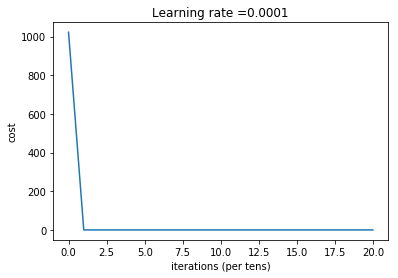

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 1.0


In [207]:
parameters = model(X_train_network, Y_train_network, X_test_network, Y_test_network, num_epochs=101)

We see that in essentially no time, this simple neural network found parameters that fit the training set perfectly AND still performed perfectly on the test set. I'll need to investigate whether this is result is real or if I made a mistake setting up this network...

***

<div align="right">
    <a href="#toc">back to top</a>
</div>

## That's it!

We've seen that it is possible to predict (with great accuracy) whether a new League of Legends player will ge through their tutorial matches (reach summoner level 3) or not, based only on the gameplay data of that player's first match!

***